work onn VISION dataset:
work on DO1 camera only

CALCULATING THE PRNU FOR A SPECIFIC CAMERA:
1. get all flat images in one folder - Sali
2. convert flat images to grayscale - Sali
3. denoising (using wavelet) - Aditya 
4. calculate noise residual (original - denoise image) for each image in the flat images - Aditya
5. calculate: equation in image "eq1' - Sali
6. calculate CRLB  in image 'eq2' - Sali

7. calculate linear pattern in image 'eq3', this is K which is the PRNU - write the equation in code format - Kavan
8. calculate conversion from RGB to grayscale in image 'eq4' or explore other conversion methods - Kavan

CALCULATING THE SIMILARITY BETWEEN A CAMERA'S FINGERPRINT AND A NEW TEST IMAGE:
work with natural images for camera DO1
9. calculate the noise residual (original image - denoised image)  (W2) noise residual for test image - Sri

#########################################

10. calculate X and Y in equations in img 'eq5'
11. Calculate the NCC in img 'eq6'
12. calculate the PCE in img 'eq7'



### Moving images to folder

In [2]:
import shutil

In [3]:
# def move_images_to_folder(camera_dir, output_dir):
#     list_of_cameras = [f'D{str(i).zfill(2)}' for i in range(1, 37)]
#     subdirs = ['flat', 'nat', 'natFBH', 'natFBL', 'natWA']

#     for cam in list_of_cameras:
        
#         cam_dir = os.path.join(output_dir, cam)
#         os.makedirs(cam_dir, exist_ok=True)  
#         subdirs = ['flat', 'nat', 'natFBH', 'natFBL', 'natWA']

#         for sub in subdirs:
#             sub_dir = os.path.join(cam_dir, sub)
#             os.makedirs(sub_dir, exist_ok=True)

#     for image in os.listdir(camera_dir):
#         if image.endswith('.jpg') or image.endswith('.png'):
#             image_parts = image.split('_')

#             camera_id = image_parts[0]
#             subdir = image_parts[2]
#             current_img_path = os.path.join(camera_dir, image)
#             new_img_path = os.path.join(output_dir, camera_id, subdir, image)

#             try:
#                 shutil.copy(current_img_path, new_img_path)
#             except FileNotFoundError:
#                 print(f"Error: {current_img_path} not found.")
#             except Exception as e:
#                 print(f"Error copying {image}: {e}")
    
# move_images_to_folder('/data/Sali/camera_fingerprint/', images_output_dir)

### Extracting PRNU

In [3]:
import pywt
from glob import glob
from tqdm import tqdm
import os
import cv2
import numpy as np
from multiprocessing import Pool, cpu_count
from sklearn.model_selection import train_test_split
import bm3d
from skimage import io, img_as_float
import matplotlib.pyplot as plt
from PIL import Image

# for denoising:
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio


#### Below is the implementation of deniosing and noise residual technique by specifying each image path. The below code can generate residual and it compares original and denoised and residual for visualization purposes.

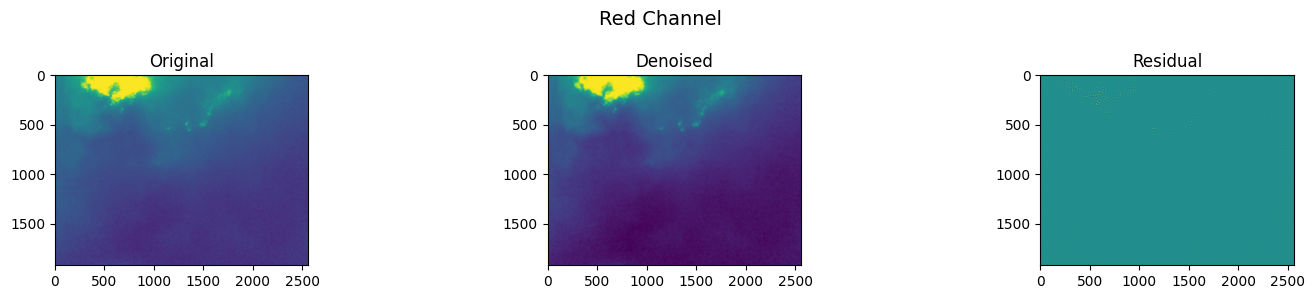

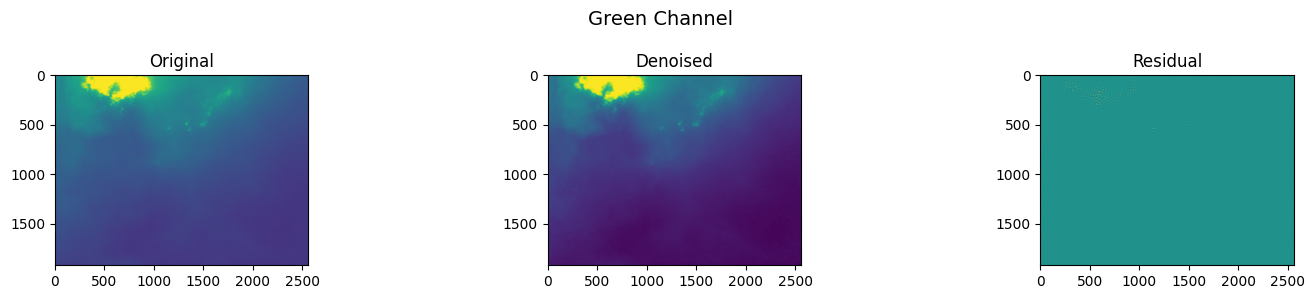

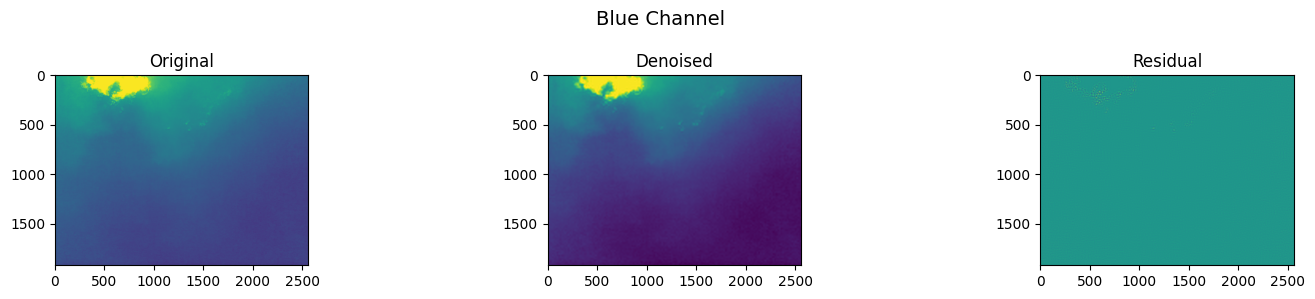

In [ ]:


# --- Configuration --- #
WAVELET = 'db8'
LEVEL = 4

# --- Wavelet Denoising for One Channel --- #
def wavelet_denoise(img_channel, wavelet=WAVELET, level=LEVEL):
    coeffs = pywt.wavedec2(img_channel, wavelet=wavelet, level=level)
    cA, cD = coeffs[0], coeffs[1:]

    # Remove high frequency details
    cD_filtered = []
    for detail in cD:
        cH, cV, cD = detail
        cH.fill(0)
        cV.fill(0)
        cD.fill(0)
        cD_filtered.append((cH, cV, cD))

    coeffs_filtered = [cA] + cD_filtered
    denoised = pywt.waverec2(coeffs_filtered, wavelet)
    return np.clip(denoised, 0, 255)

# --- Denoise and Compute Residual for RGB --- #
def process_rgb_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = img.astype(np.float32)
    B, G, R = cv2.split(img)

    R_denoised = wavelet_denoise(R)
    G_denoised = wavelet_denoise(G)
    B_denoised = wavelet_denoise(B)

    R_residual = R - R_denoised
    G_residual = G - G_denoised
    B_residual = B - B_denoised

    return (R, R_denoised, R_residual), (G, G_denoised, G_residual), (B, B_denoised, B_residual)

# --- Run on one RGB image --- #
image_path = "/home/adityabe/Desktop/camera_fingerprint/D01/flat/D01_I_flat_0033.jpg"  # <- Replace this path
R_data, G_data, B_data = process_rgb_image(image_path)

# --- Visualize Results --- #
def show_channel_results(channel_data, channel_name):
    original, denoised, residual = channel_data
    plt.figure(figsize=(15, 3))
    plt.suptitle(f'{channel_name} Channel', fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Original')

    plt.subplot(1, 3, 2)
    plt.imshow(denoised)
    plt.title('Denoised')

    plt.subplot(1, 3, 3)
    plt.imshow(residual)
    plt.title('Residual')

    plt.tight_layout()
    plt.show()

show_channel_results(R_data, 'Red')
show_channel_results(G_data, 'Green')
show_channel_results(B_data, 'Blue')


### Below impolementation is for all the images in the path. You cannot visualize the residuals but can just compute it. So, just continue to write the code for estimating the PRNU.

In [5]:
from PIL import Image
from glob import glob
import os

images_dir = './D01/flat/'
image_paths = glob(os.path.join(images_dir, '*.jpg'))

for path in image_paths:
    try:
        with Image.open(path) as img:
            img.verify()  # checks for corruption
    except Exception as e:
        print(f"❌ Corrupted: {os.path.basename(path)} — {e}")


In [ ]:
# --- Configuration --- #
WAVELET = 'db8'
LEVEL = 4

# --- Wavelet Denoising for One Channel --- #
def wavelet_denoise(img_channel, wavelet=WAVELET, level=LEVEL):
    coeffs = pywt.wavedec2(img_channel, wavelet=wavelet, level=level)
    cA, cD = coeffs[0], coeffs[1:]

    # Remove high frequency details
    cD_filtered = []
    for detail in cD:
        cH, cV, cD = detail
        cH.fill(0)
        cV.fill(0)
        cD.fill(0)
        cD_filtered.append((cH, cV, cD))

    coeffs_filtered = [cA] + cD_filtered
    denoised = pywt.waverec2(coeffs_filtered, wavelet)
    return np.clip(denoised, 0, 255)

# --- Read Image Safely with PIL --- #
def read_image_pil(path):
    try:
        with Image.open(path) as img:
            img = img.convert('RGB')  # ensures 3 channels
            img_np = np.array(img).astype(np.float32)
            return img_np
    except Exception as e:
        print(f"❌ Error reading image {path} with PIL: {e}")
        return None

# --- Denoise and Compute Residual for RGB --- #
def process_rgb_image(image_path):
    img = read_image_pil(image_path)
    if img is None:
        return None, None, None

    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    R_denoised = wavelet_denoise(R)
    G_denoised = wavelet_denoise(G)
    B_denoised = wavelet_denoise(B)

    R_residual = R - R_denoised
    G_residual = G - G_denoised
    B_residual = B - B_denoised

    return R_residual, G_residual, B_residual

# --- Process all images in a folder --- #
def estimate_PRNU(images_dir):
    image_paths = glob(os.path.join(images_dir, '*.jpg'))

    for path in tqdm(image_paths, desc="Processing images"):
        result = process_rgb_image(path)
        if result is None:
            continue
        R_residual, G_residual, B_residual = result

        ## Proceed to code further in this function for using the residuals for calculating PRNU (equation. 1) for each channel.
        ## In equation 1, calculate the numerator term for each channel of each image and denominator is square of each channel of each image. Resulting is the summamtion of this numerator and denominator for each channel.
        ## You get KR, KG, KB for each channel.
        ## Combine the PRNU of three channels to get the final PRNU using K = 0.3 * K_R + 0.6 * K_G + 0.1 * K_B
        # And then you also have to subtract the column and row artifacts from the PRNU.


In [ ]:
# --- Example usage --- #
images_dir = './D01/flat/'  # Replace with your folder path
# R_residuals, G_residuals, B_residuals = estimate_PRNU(images_dir)

Processing images:  22%|██▏       | 17/78 [01:10<10:48, 10.62s/it]

: 

In [ ]:

https://github.com/samuelebortolotti/neural-prnu-extractor #code to replicate
https://github.com/ocrim1996/prnu-python?tab=readme-ov-file
https://ieeexplore.ieee.org/document/7791195 # image alignment 
https://ieeexplore.ieee.org/document/7791195 # paper that talks about denoising filter
https://paperswithcode.com/sota/image-denoising-on-sidd # papers with code
https://www.reddit.com/r/AirlinerAbduction2014/comments/1fnxy5o/photo_response_nonuniformity_prnu_authentication/#:~:text=Extracting%20the%20PRNU%20requires%20denoising,is%20compared%20to%20the%20CRP. # reddit page

SyntaxError: invalid syntax (4290831171.py, line 1)